## Swing Model
### Goal:
- create model that is overfit to extrapolate short-term trends for the purpose of techincal analysis. 

- I'll work on Close first. If it meets expectations, I'll expand create models for Open, High, & Low as well. If this is not TOO computationally expensive, then I'll implement all four models in my app.

* Its important to have some distinctions. The correct way to train a model will result in forecasts that will have the smallest error - and be closest to actual data. We can base this on results from cross-validation and KPI's like Mean Absolute Percentage Error. Instead, I want a model that matches visual patterns, but is not necessarily numerically accurate, to observe potential trends in the data.

In [1]:
import sys
sys.path.append("/Users/shaneypeterson/Desktop/2024.06.27_-_Data_Science/Modules")

In [2]:
import stocks as st
import numpy as np
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly
from plotly import graph_objs as go
import streamlit
import timeit
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
from datetime import date

In [3]:
st = st.Stocks()

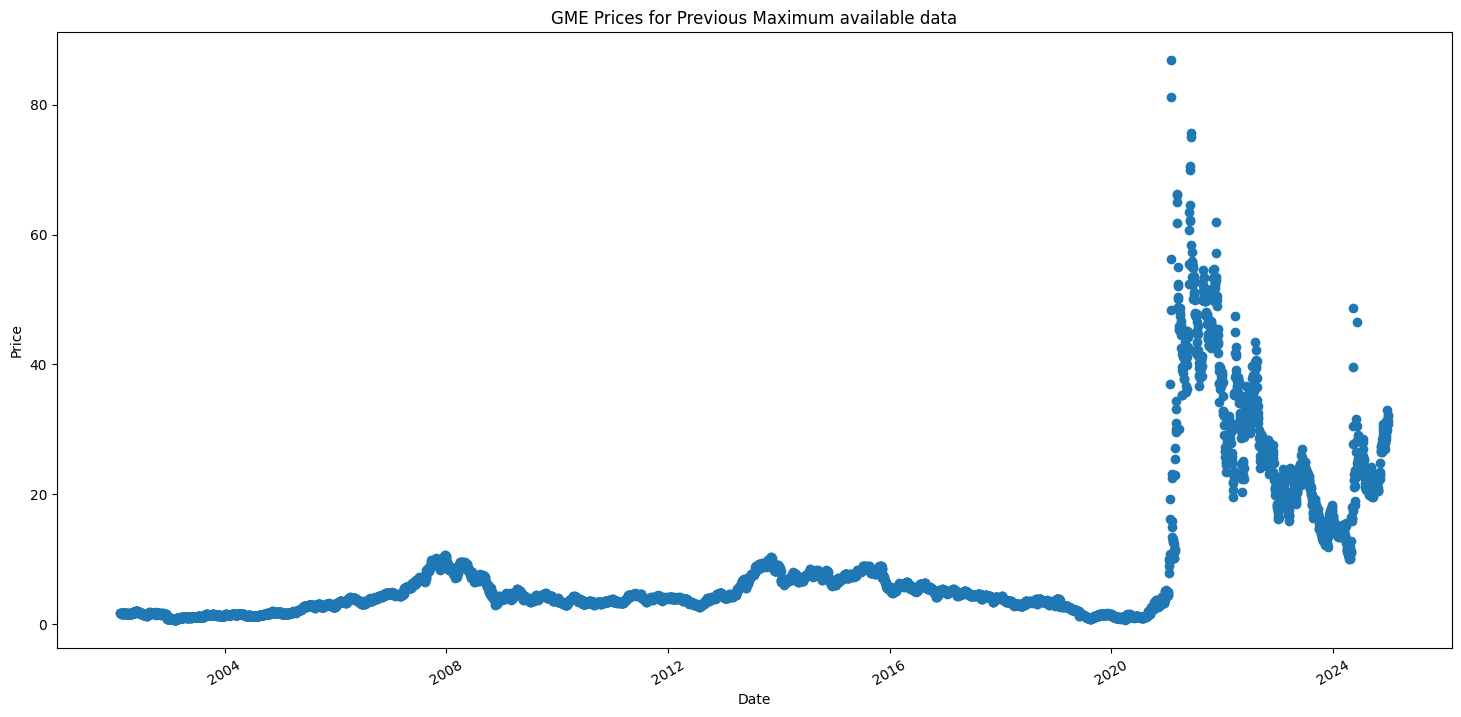

Closing price as of 2025-01-02: $30.83
The percentage change over previous Maximum available data is 1803%
Dividends total $2.39
Stock Splits total $6.0
'Capital Gains' not found in data


In [4]:
df = st.stats_generator('gme')

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-02-13 00:00:00-05:00,1.620128,1.693350,1.603296,1.691666,76216000,0.0,0.0
1,2002-02-14 00:00:00-05:00,1.712707,1.716074,1.670626,1.683250,11021600,0.0,0.0
2,2002-02-15 00:00:00-05:00,1.683251,1.687459,1.658002,1.674834,8389600,0.0,0.0
3,2002-02-19 00:00:00-05:00,1.666418,1.666418,1.578047,1.607504,7410400,0.0,0.0
4,2002-02-20 00:00:00-05:00,1.615921,1.662210,1.603296,1.662210,6892800,0.0,0.0


In [6]:
# remove timezone
import pandas as pd

df['Date'] = pd.to_datetime(df['Date']).dt.date

In [7]:
def dynamic_winsorize(df, column, window_size=30, percentiles=(0.05, 0.95)):
    """
    Winsorizes data within a rolling window.

    Args:
        df: DataFrame containing the data.
        column: Name of the column to winsorize.
        window_size: Size of the rolling window.
        percentiles: Tuple containing the lower and upper percentiles.

    Returns:
        DataFrame with the winsorized column.
    """

    df['rolling_lower'] = df[column].rolling(window=window_size).quantile(percentiles[0])
    df['rolling_upper'] = df[column].rolling(window=window_size).quantile(percentiles[1])

    df['winsorized'] = df[column]
    df.loc[df[column] < df['rolling_lower'], 'winsorized'] = df['rolling_lower']
    df.loc[df[column] > df['rolling_upper'], 'winsorized'] = df['rolling_upper']

    return df

# Apply dynamic winsorization
df = dynamic_winsorize(df, 'Close')

In [8]:
df[df['Close'] != df['winsorized']].head() # dynamic_winsorize() check

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,rolling_lower,rolling_upper,winsorized
32,2002-04-02,1.599088,1.599088,1.544382,1.568789,2098400,0.0,0.0,1.571062,1.77604,1.571062
33,2002-04-03,1.569631,1.582255,1.551957,1.565423,567200,0.0,0.0,1.566938,1.77604,1.566938
35,2002-04-05,1.594880,1.632753,1.556165,1.556165,837600,0.0,0.0,1.560331,1.77604,1.560331
36,2002-04-08,1.565423,1.565423,1.495568,1.540174,1558400,0.0,0.0,1.547370,1.77604,1.547370
40,2002-04-12,1.569631,1.569631,1.519975,1.535966,1236000,0.0,0.0,1.537860,1.77604,1.537860


In [9]:
# format new dataset for model with 'ds' and 'y' for prophet model

df_train = df[['Date' ,'Close', 'winsorized']]
df_train = df_train.rename(columns={'Date': 'ds', 'winsorized': 'y'})

In [10]:
# limit to only previous year

df_train = df_train[-365:]

In [11]:
df_train.tail()

,ds,Close,y
5756,2024-12-26,32.990002,31.206000
5757,2024-12-27,32.200001,31.777001
5758,2024-12-30,32.009998,32.009998
5759,2024-12-31,31.340000,31.340000
5760,2025-01-02,30.830000,30.830000


In [12]:
# create function for model accuracy

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def get_model_accuracy(y_column, forecast):
    # Extract actual and predicted values without forecasted period
    y_true = y_column[-period:]
    y_pred = forecast['yhat'][-period:]

    # Calculate accuracy metrics
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Mean Absolute Error': mae,
        'Mean Absolute Percentage Error': mape,
        'Mean Squared Error': mse,
        'Root Mean Squared Error': rmse
        },
        index=[0])
    
    return metrics_df

In [13]:
# create baseline model

m1 = Prophet(
            # changepoint_prior_scale=20,
            #  n_changepoints=200,
            #  seasonality_prior_scale=100
             )
m1.fit(df_train)

13:09:03 - cmdstanpy - INFO - Chain [1] start processing
13:09:03 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
period = 30

future = m1.make_future_dataframe(periods=period)
forecast = m1.predict(future)

In [15]:
get_model_accuracy(df_train.Close, forecast)

,Mean Absolute Error,Mean Absolute Percentage Error,Mean Squared Error,Root Mean Squared Error
0,1.444354,0.048177,3.27774,1.810453


In [20]:
forecast['actual_close'] = df.Close

ValueError: You are trying to merge on datetime64[ns] and object columns for key 'ds'. If you wish to proceed you should use pd.concat

In [17]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,actual_close
0,2023-07-24,20.627195,16.031819,23.867804,20.627195,20.627195,-0.650186,-0.650186,-0.650186,-0.650186,-0.650186,-0.650186,0.0,0.0,0.0,19.977009,1.691666
1,2023-07-25,20.576845,16.218547,24.215171,20.576845,20.576845,-0.323967,-0.323967,-0.323967,-0.323967,-0.323967,-0.323967,0.0,0.0,0.0,20.252878,1.683250
2,2023-07-26,20.526495,15.933543,23.877127,20.526495,20.526495,-0.533351,-0.533351,-0.533351,-0.533351,-0.533351,-0.533351,0.0,0.0,0.0,19.993144,1.674834
3,2023-07-27,20.476145,16.028181,24.088768,20.476145,20.476145,-0.314206,-0.314206,-0.314206,-0.314206,-0.314206,-0.314206,0.0,0.0,0.0,20.161938,1.607504
4,2023-07-28,20.425795,15.899126,23.730215,20.425795,20.425795,-0.529615,-0.529615,-0.529615,-0.529615,-0.529615,-0.529615,0.0,0.0,0.0,19.896180,1.662210


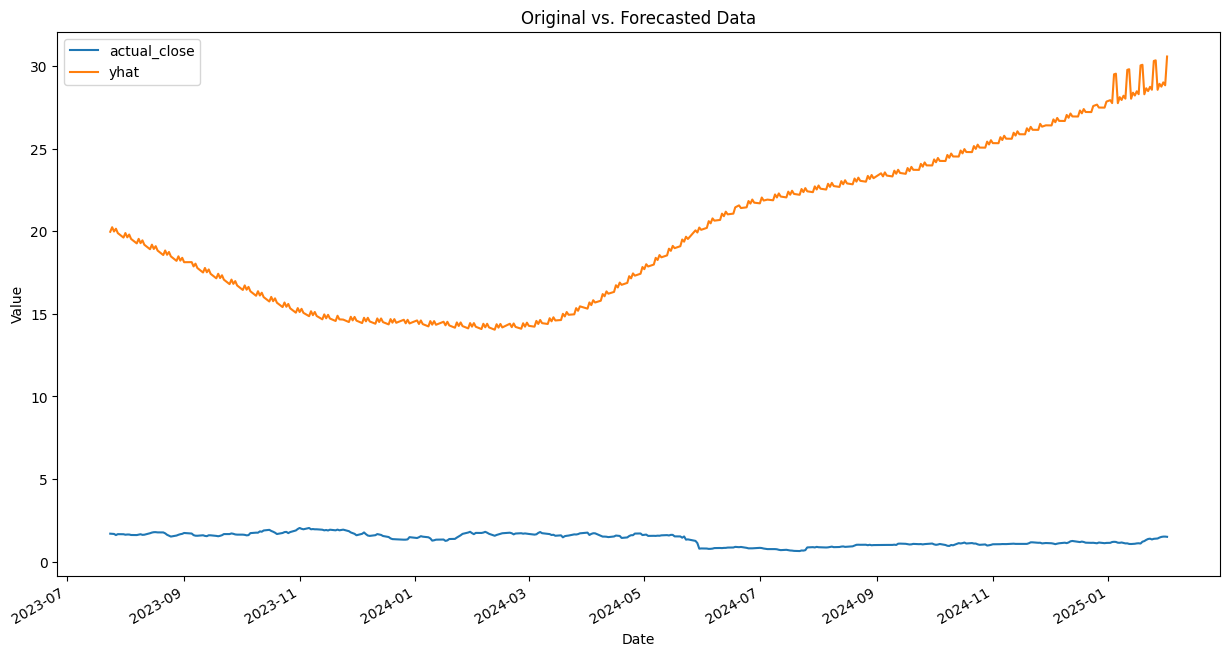

In [18]:
# get visual

fig, ax = plt.subplots(figsize=(15, 8))

# Plot 'y' and 'winsorized_data' on the same graph
forecast.plot(x='ds', y=['actual_close', 'yhat'], ax=ax)

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original vs. Forecasted Data')
plt.legend()

# Show the plot
plt.show()

In [19]:
# get interactive visual

# Plot Forecast
fig1 = plot_plotly(m1, forecast)
# fig1.layout.update(title_text=f"Forecast for 1 Year: {ticker_name} '{selected_stock}'")
fig1.update_layout(yaxis_title='Price')
fig1.update_layout(xaxis_title='Date')
# ADD LEGEND <<<<<
# Calculate default date range
end_date = forecast['ds'].max()
start_date = end_date - pd.Timedelta(days=1095)
fig1.update_xaxes(range=[start_date, end_date])
# fig1.update_layout(xaxis_rangeslider_visible=False)
fig1

### This process is not working. I need to change the goal of project to focus on accuracy, not shape